# Building Semantic Memory with Embeddings

So far, we've mostly been treating the kernel as a stateless orchestration engine.
We send text into a model API and receive text out. 

In a [previous notebook](04-context-variables-chat.ipynb), we used `context variables` to pass in additional
text into prompts to enrich them with more context. This allowed us to create a basic chat experience. 

However, if you solely relied on context variables, you would quickly realize that eventually your prompt
would grow so large that you would run into the model's token limit. What we need is a way to persist state
and build both short-term and long-term memory to empower even more intelligent applications. 

To do this, we dive into the key concept of `Semantic Memory` in the Semantic Kernel. 

In [ ]:
!python -m pip install semantic-kernel==0.3.15.dev0

In [1]:
from typing import Tuple

import semantic_kernel as sk
from semantic_kernel.connectors.ai.open_ai import OpenAIChatCompletion, OpenAITextEmbedding, AzureChatCompletion, AzureTextEmbedding

In order to use memory, we need to instantiate the Kernel with a Memory Storage
and an Embedding service. In this example, we make use of the `VolatileMemoryStore` which can be thought of as a temporary in-memory storage. This memory is not written to disk and is only available during the app session.

When developing your app you will have the option to plug in persistent storage like Azure AI Search, Azure Cosmos Db, PostgreSQL, SQLite, etc. Semantic Memory allows also to index external data sources, without duplicating all the information as you will see further down in this notebook.

In [2]:
kernel = sk.Kernel()

useAzureOpenAI = True

# Configure AI service used by the kernel
if useAzureOpenAI:
    deployment, api_key, endpoint = sk.azure_openai_settings_from_dot_env()
    kernel.add_chat_service("chat_completion", AzureChatCompletion(deployment, endpoint, api_key))
    # next line assumes embeddings deployment name is "text-embedding-ada-002", adjust this if  appropriate 
    kernel.add_text_embedding_generation_service("ada", AzureTextEmbedding("text-embedding-ada-002", endpoint, api_key))
else:
    api_key, org_id = sk.openai_settings_from_dot_env()
    kernel.add_chat_service("chat-gpt", OpenAIChatCompletion("gpt-3.5-turbo", api_key, org_id))
    kernel.add_text_embedding_generation_service("ada", OpenAITextEmbedding("text-embedding-ada-002", api_key, org_id))

kernel.register_memory_store(memory_store=sk.memory.VolatileMemoryStore())
kernel.import_skill(sk.core_skills.TextMemorySkill())

{'recall': <semantic_kernel.orchestration.sk_function.SKFunction at 0x2180668e0d0>,
 'save': <semantic_kernel.orchestration.sk_function.SKFunction at 0x218066ace50>}

At its core, Semantic Memory is a set of data structures that allow you to store the meaning of text that come from different data sources, and optionally to store the source text too. These texts can be from the web, e-mail providers, chats, a database, or from your local directory, and are hooked up to the Semantic Kernel through data source connectors.

The texts are embedded or compressed into a vector of floats representing mathematically the texts' contents and meaning. You can read more about embeddings [here](https://aka.ms/sk/embeddings).

### Manually adding memories
Let's create some initial memories "About Me". We can add memories to our `VolatileMemoryStore` by using `SaveInformationAsync`

In [3]:
async def populate_memory(kernel: sk.Kernel) -> None:
    # Add some documents to the semantic memory
    await kernel.memory.save_information_async(
        "aboutMe", id="info1", text="My name is Andrea"
    )
    await kernel.memory.save_information_async(
        "aboutMe", id="info2", text="I currently work as a tour guide"
    )
    await kernel.memory.save_information_async(
        "aboutMe", id="info3", text="I've been living in Seattle since 2005"
    )
    await kernel.memory.save_information_async(
        "aboutMe", id="info4", text="I visited France and Italy five times since 2015"
    )
    await kernel.memory.save_information_async(
        "aboutMe", id="info5", text="My family is from New York"
    )

In [4]:
await populate_memory(kernel)

Let's try searching the memory:

In [5]:
async def search_memory_examples(kernel: sk.Kernel) -> None:
    questions = [
        "what's my name",
        "where do I live?",
        "where's my family from?",
        "where have I traveled?",
        "what do I do for work",
    ]

    for question in questions:
        print(f"Question: {question}")
        result = await kernel.memory.search_async("aboutMe", question)
        print(f"Answer: {result[0].text}\n")

In [6]:
await search_memory_examples(kernel)

Question: what's my name
Answer: My name is Andrea

Question: where do I live?
Answer: I've been living in Seattle since 2005

Question: where's my family from?
Answer: My family is from New York

Question: where have I traveled?
Answer: I visited France and Italy five times since 2015

Question: what do I do for work
Answer: I currently work as a tour guide



Let's now revisit the our chat sample from the [previous notebook](04-context-variables-chat.ipynb).
If you remember, we used context variables to fill the prompt with a `history` that continuously got populated as we chatted with the bot. Let's add also memory to it!

This is done by using the `TextMemorySkill` which exposes the `recall` native function.

`recall` takes an input ask and performs a similarity search on the contents that have
been embedded in the Memory Store and returns the most relevant memory. 

In [7]:
async def setup_chat_with_memory(
    kernel: sk.Kernel,
) -> Tuple[sk.SKFunctionBase, sk.SKContext]:
    sk_prompt = """
    ChatBot can have a conversation with you about any topic.
    It can give explicit instructions or say 'I don't know' if
    it does not have an answer.

    Information about me, from previous conversations:
    - {{$fact1}} {{recall $fact1}}
    - {{$fact2}} {{recall $fact2}}
    - {{$fact3}} {{recall $fact3}}
    - {{$fact4}} {{recall $fact4}}
    - {{$fact5}} {{recall $fact5}}

    Chat:
    {{$chat_history}}
    User: {{$user_input}}
    ChatBot: """.strip()

    chat_func = kernel.create_semantic_function(sk_prompt, max_tokens=200, temperature=0.8)

    context = kernel.create_new_context()
    context["fact1"] = "what is my name?"
    context["fact2"] = "where do I live?"
    context["fact3"] = "where's my family from?"
    context["fact4"] = "where have I traveled?"
    context["fact5"] = "what do I do for work?"

    context[sk.core_skills.TextMemorySkill.COLLECTION_PARAM] = "aboutMe"
    context[sk.core_skills.TextMemorySkill.RELEVANCE_PARAM] = 0.8

    context["chat_history"] = ""

    return chat_func, context

The `RelevanceParam` is used in memory search and is a measure of the relevance score from 0.0 to 1.0, where 1.0 means a perfect match. We encourage users to experiment with different values.

Now that we've included our memories, let's chat!

In [8]:
async def chat(
    kernel: sk.Kernel, chat_func: sk.SKFunctionBase, context: sk.SKContext
) -> bool:
    try:
        user_input = input("User:> ")
        context["user_input"] = user_input
        print(f"User:> {user_input}")
    except KeyboardInterrupt:
        print("\n\nExiting chat...")
        return False
    except EOFError:
        print("\n\nExiting chat...")
        return False

    if user_input == "exit":
        print("\n\nExiting chat...")
        return False

    answer = await kernel.run_async(chat_func, input_vars=context.variables)
    context["chat_history"] += f"\nUser:> {user_input}\nChatBot:> {answer}\n"

    print(f"ChatBot:> {answer}")
    return True

In [9]:
print("Populating memory...")
await populate_memory(kernel)

print("Asking questions... (manually)")
await search_memory_examples(kernel)

print("Setting up a chat (with memory!)")
chat_func, context = await setup_chat_with_memory(kernel)

print("Begin chatting (type 'exit' to exit):\n")
chatting = True
while chatting:
    chatting = await chat(kernel, chat_func, context)

Populating memory...
Asking questions... (manually)
Question: what's my name
Answer: My name is Andrea

Question: where do I live?
Answer: I've been living in Seattle since 2005

Question: where's my family from?
Answer: My family is from New York

Question: where have I traveled?
Answer: I visited France and Italy five times since 2015

Question: what do I do for work
Answer: I currently work as a tour guide

Setting up a chat (with memory!)
Begin chatting (type 'exit' to exit):

User:> where to go?
ChatBot:> Where are you looking to go?
User:> 
ChatBot:> I don't know. Where are you interested in going?
User:> exit


Exiting chat...


### Adding documents to your memory

Many times in your applications you'll want to bring in external documents into your memory. Let's see how we can do this using our VolatileMemoryStore.

Let's first get some data using some of the links in the Semantic Kernel repo.

In [10]:
github_files ={}
github_files["https://github.com/microsoft/semantic-kernel/blob/main/README.md"] = \
    "README: Installation, getting started, and how to contribute"
github_files["https://github.com/microsoft/semantic-kernel/blob/main/dotnet/notebooks/02-running-prompts-from-file.ipynb"] = \
    "Jupyter notebook describing how to pass prompts from a file to a semantic skill or function"
github_files["https://github.com/microsoft/semantic-kernel/blob/main/dotnet/notebooks/00-getting-started.ipynb"] = \
    "Jupyter notebook describing how to get started with the Semantic Kernel"
github_files["https://github.com/microsoft/semantic-kernel/tree/main/samples/skills/ChatSkill/ChatGPT"] = \
    "Sample demonstrating how to create a chat skill interfacing with ChatGPT"
github_files["https://github.com/microsoft/semantic-kernel/blob/main/dotnet/src/SemanticKernel/Memory/Volatile/VolatileMemoryStore.cs"] = \
    "C# class that defines a volatile embedding store"

Now let's add these files to our VolatileMemoryStore using `SaveReferenceAsync`. We'll separate these memories from the chat memories by putting them in a different collection.

In [11]:
memory_collection_name = "SKGitHub"
print("Adding some GitHub file URLs and their descriptions to a volatile Semantic Memory.");
i = 0
for entry, value in github_files.items():
    await kernel.memory.save_reference_async(
        collection=memory_collection_name,
        description=value,
        text=value,
        external_id=entry,
        external_source_name="GitHub"
    )
    i += 1
    print("  URL {} saved".format(i))

Adding some GitHub file URLs and their descriptions to a volatile Semantic Memory.
  URL 1 saved
  URL 2 saved
  URL 3 saved
  URL 4 saved
  URL 5 saved


In [12]:
ask = "I love Jupyter notebooks, how should I get started?"
print("===========================\n" + "Query: " + ask + "\n")

memories = await kernel.memory.search_async(memory_collection_name, ask, limit=5, min_relevance_score=0.77)

i = 0
for memory in memories:
    i += 1
    print(f"Result {i}:")
    print("  URL:     : " + memory.id)
    print("  Title    : " + memory.description)
    print("  Relevance: " + str(memory.relevance))
    print()

Query: I love Jupyter notebooks, how should I get started?

Result 1:
  URL:     : https://github.com/microsoft/semantic-kernel/blob/main/dotnet/notebooks/00-getting-started.ipynb
  Title    : Jupyter notebook describing how to get started with the Semantic Kernel
  Relevance: 0.8677416503246568

Result 2:
  URL:     : https://github.com/microsoft/semantic-kernel/blob/main/dotnet/notebooks/02-running-prompts-from-file.ipynb
  Title    : Jupyter notebook describing how to pass prompts from a file to a semantic skill or function
  Relevance: 0.8165638330414676

Result 3:
  URL:     : https://github.com/microsoft/semantic-kernel/blob/main/README.md
  Title    : README: Installation, getting started, and how to contribute
  Relevance: 0.8086321980724277



Now you might be wondering what happens if you have so much data that it doesn't fit into your RAM? That's where you want to make use of an external Vector Database made specifically for storing and retrieving embeddings. Fortunately, semantic kernel makes this easy thanks to an extensive list of available connectors. In the following section, we will connect to an existing Azure AI Search service that we will use as an external Vector Database to store and retrieve embeddings.


In [13]:
from semantic_kernel.connectors.memory.azure_cognitive_search import AzureCognitiveSearchMemoryStore

azure_ai_search_api_key, azure_ai_search_url = sk.azure_aisearch_settings_from_dot_env()
kernel.register_memory_store(memory_store=AzureCognitiveSearchMemoryStore(1536,search_endpoint=azure_ai_search_url,admin_key=azure_ai_search_api_key))


The implementation of Semantic Kernel allows to easily swap memory store for another. Here, we will re-use the functions we initially created for `VolatileMemoryStore` with our new external Vector Store leveraging Azure AI Search

In [14]:
await populate_memory(kernel)

hnsw_parameters is not a known attribute of class <class 'azure.search.documents.indexes._generated.models._models_py3.HnswVectorSearchAlgorithmConfiguration'> and will be ignored


We can see that our function created an "About Me" index and that our five pieces of infomation have been indexed (note that it can take a few minutes for the UI to reflect the document count and storage size).

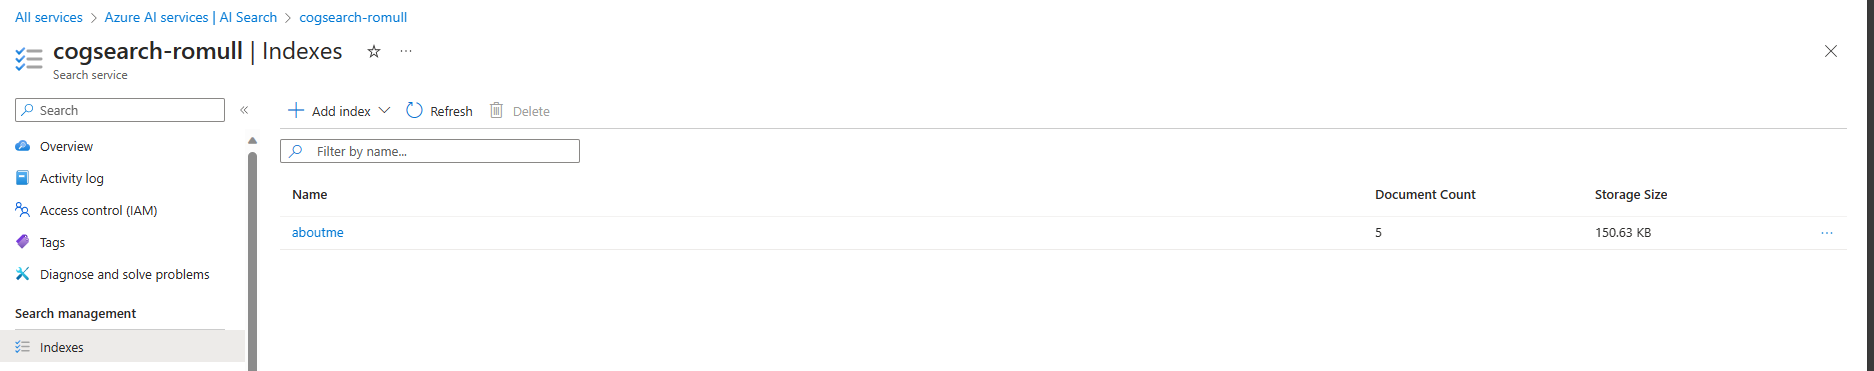

And we can see that embeddings have been conveniently created to allow for semantic search.

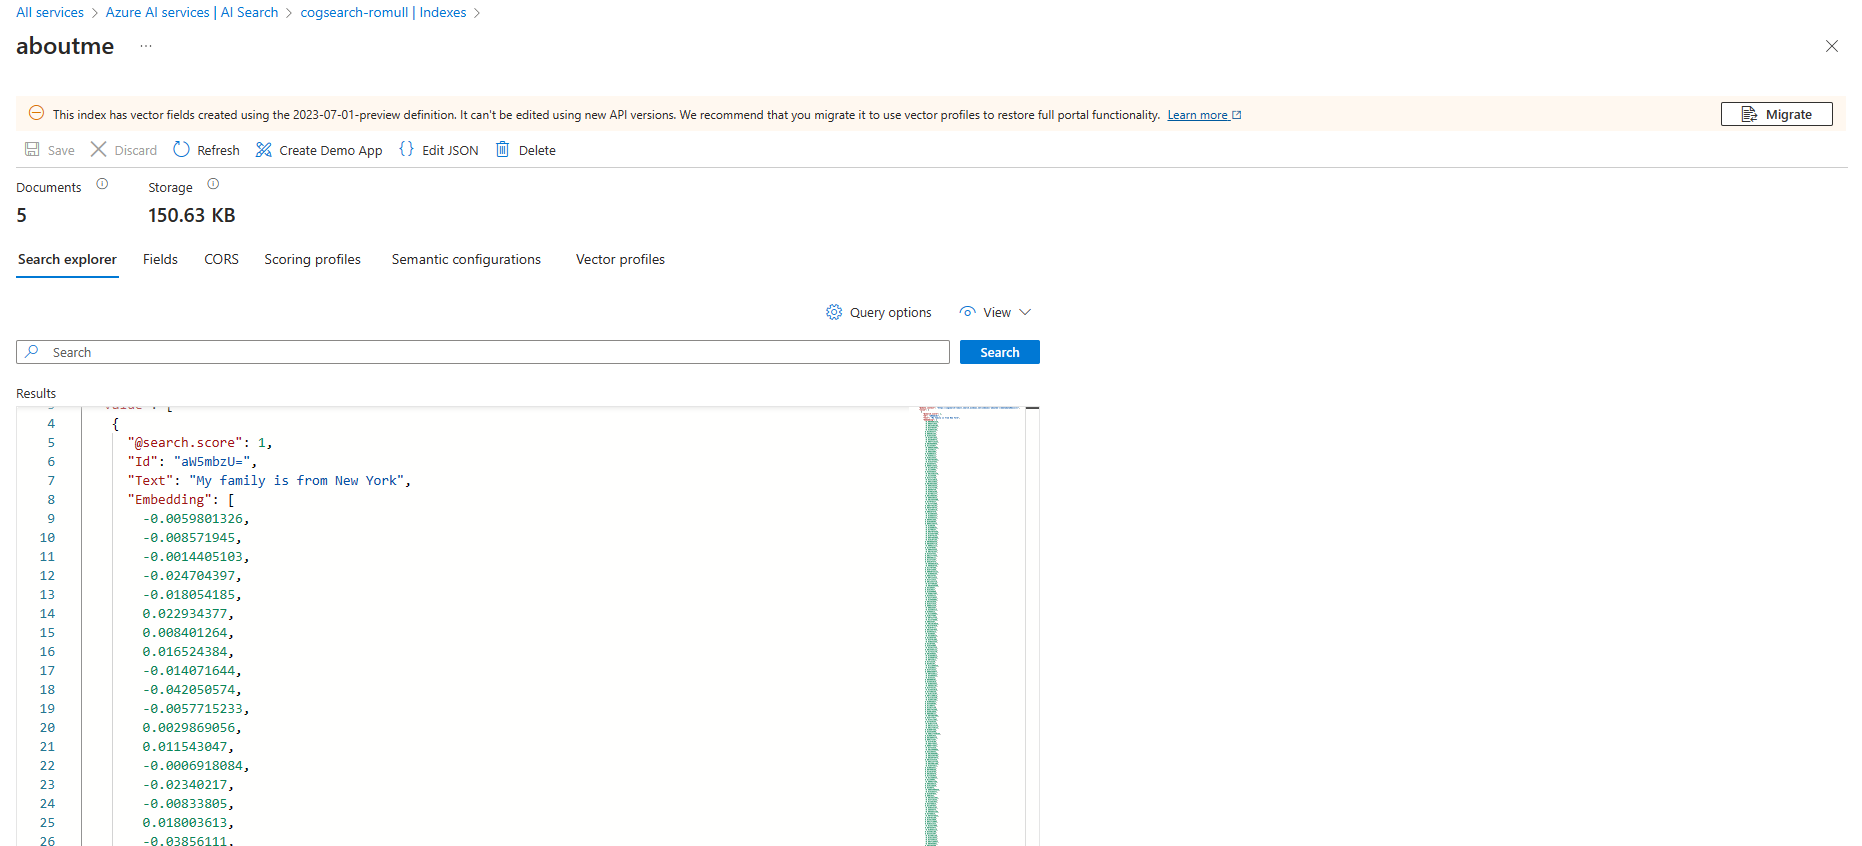

Let's now try to query from Azure AI Search!

In [15]:
await search_memory_examples(kernel)

Question: what's my name
Answer: My name is Andrea

Question: where do I live?
Answer: I've been living in Seattle since 2005

Question: where's my family from?
Answer: My family is from New York

Question: where have I traveled?
Answer: I visited France and Italy five times since 2015

Question: what do I do for work
Answer: I currently work as a tour guide



We have laid the foundation which will allow us to store an abitrary amount of data in an external Vector Store above and beyond what could fit in memory at the expense of a little more latency.